# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных
Признаки


- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired  — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

загрузим необходимое для работы


In [1]:
!pip3 install catboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip3 install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip3 install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from random import randint
from tqdm import tqdm_notebook

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

загрузим и проверим данные

In [5]:
data = pd.read_csv("autos.csv")
data.head()
data.info()
len_data_original = len(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

переименуем столбцы к нужному стилю

In [6]:
data.columns = data.columns.str.lower()
data = data.rename(columns={'datecrawled':'date_crawled',
                        'vehicletype':'vehicle_type',
                        'registrationyear':'registration_year',
                        'registrationmonth':'registration_month',
                        'fueltype':'fuel_type',
                        'notrepaired':'not_repaired',
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

узнаем какая последняя дата в данных

In [7]:
print('Крайняя дата выгрузки:', data['date_crawled'].max())

Крайняя дата выгрузки: 2016-04-07 14:36:58


посмотрим на значения в колонках

In [8]:
print('Уникальные значения')
for col in data.columns:
    print(col, ':', data[col].unique())

Уникальные значения
date_crawled : ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
price : [  480 18300  9800 ... 12395 18429 10985]
vehicle_type : [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
registration_year : [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600

посмотрим на пропущенные значения

In [9]:
pd.concat([data.isna().sum(), (data.isna().sum() / len(data)) * 100], axis=1, keys=['количество', 'процент'])


,количество,процент
date_crawled,0,0.000000
price,0,0.000000
vehicle_type,37490,10.579368
registration_year,0,0.000000
gearbox,19833,5.596709
power,0,0.000000
model,19705,5.560588
kilometer,0,0.000000
registration_month,0,0.000000
fuel_type,32895,9.282697


In [10]:
print('Количество дуюликатов', data.duplicated().sum())
print('процент ко всем данным', data.duplicated().sum()/len(data)*100)
data[data.duplicated()]

Количество дуюликатов 4
процент ко всем данным 0.0011287669068118262


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


удалим дубликаты

In [11]:
data = data.drop_duplicates().reset_index(drop=True)

удалим данные не повливющие на обучении наших моделей

In [12]:
data = data.drop(['date_crawled', 'registration_month', 'date_created',
                  'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [13]:
print('Количество дуюликатов', data.duplicated().sum())
print('процент ко всем данным', data.duplicated().sum()/len(data)*100)
data[data.duplicated()]


Количество дуюликатов 45036
процент ко всем данным 12.708930057991056


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
1117,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no
1396,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
2169,0,coupe,2002,manual,129,c_klasse,150000,petrol,mercedes_benz,no
2833,1499,small,2001,manual,58,corsa,150000,petrol,opel,no
3025,2800,wagon,2005,NaN,0,touran,150000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354348,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no
354351,4400,sedan,2008,manual,105,leon,150000,gasoline,seat,no
354354,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
354355,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no


стало больше дубликатов данных, они нам не нужны - удалим

In [14]:
data = data.drop_duplicates().reset_index(drop=True)

заменим repaired на целочисленный тип, пропуски означают что ремонте небыло

In [15]:
#Заменим yes на 1 , no на 0
data['repaired'] = data['repaired'].map({'yes':1, 'no':0}).fillna(0).astype('int64')


### Выбросы

#### Год регистрации

ограничемся автомобилями < датой выгрузки данных и 1900

In [16]:
data = data.loc[(data['registration_year'] <= 2016) & (data['registration_year'] >= 1900)]

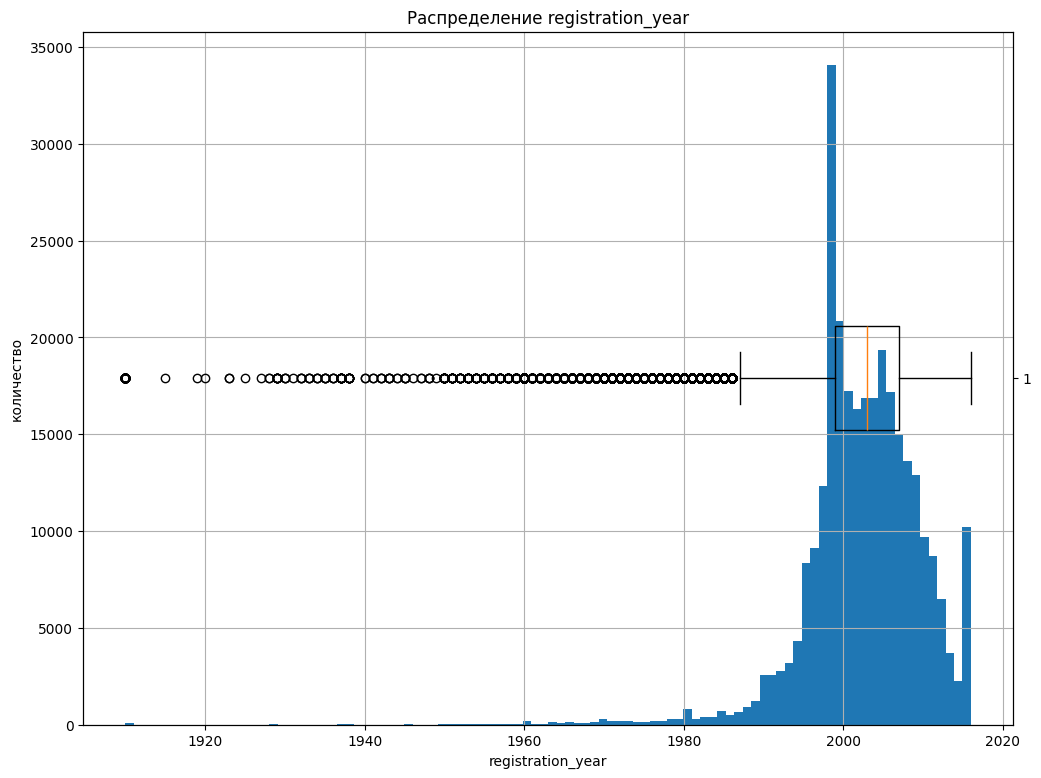

In [17]:
fig, ax = plt.subplots(figsize=(12, 9))

# Гистограмма
data['registration_year'].dropna().hist(bins=100, ax=ax)
ax.set_xlabel('registration_year')
ax.set_ylabel('количество')

# Ящик с усами
ax2 = ax.twinx()
ax2.boxplot(data['registration_year'], vert=False)

plt.title('Распределение registration_year')
plt.show()

In [18]:
data = data.loc[(data['registration_year'] >= data['registration_year'].quantile(0.05))]


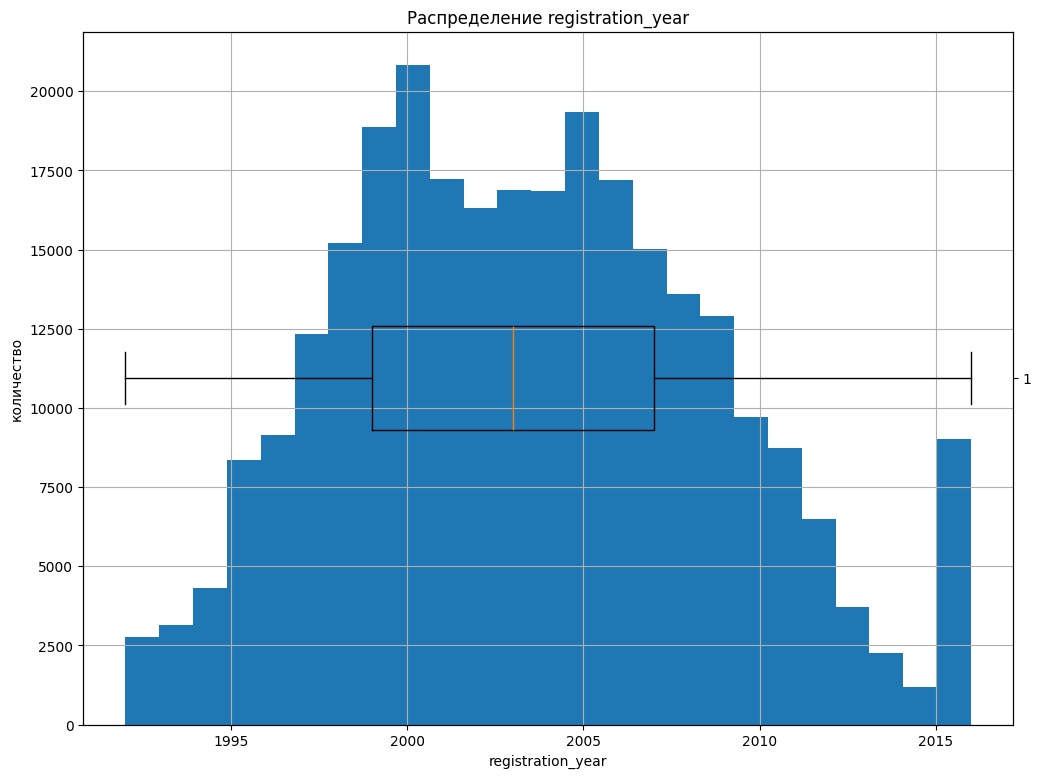

In [19]:
fig, ax = plt.subplots(figsize=(12, 9))

# Гистограмма
data['registration_year'].dropna().hist(bins=25, ax=ax)
ax.set_xlabel('registration_year')
ax.set_ylabel('количество')

# Ящик с усами
ax2 = ax.twinx()
ax2.boxplot(data['registration_year'], vert=False)

plt.title('Распределение registration_year')
plt.show()

Мощность двигателя

In [20]:
data['power'].value_counts()

power
0       29189
75      17813
150     12003
60      11865
140     10503
        ...  
850         1
337         1
8011        1
2331        1
1241        1
Name: count, Length: 681, dtype: int64

ограничемся >0 и <1300 т.к. это слишком много

In [21]:
data = data[(data['power']<=1300)&(data['power']>0)]

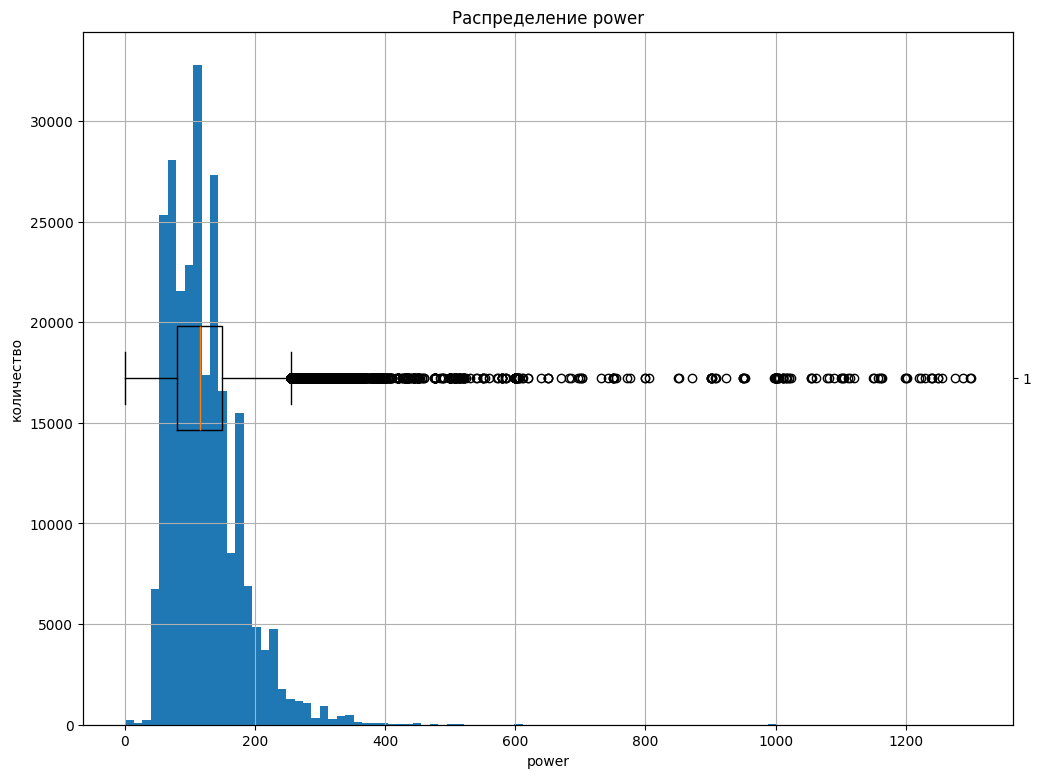

In [22]:
fig, ax = plt.subplots(figsize=(12, 9))

# Гистограмма
data['power'].dropna().hist(bins=100, ax=ax)
ax.set_xlabel('power')
ax.set_ylabel('количество')

# Ящик с усами
ax2 = ax.twinx()
ax2.boxplot(data['power'], vert=False)

plt.title('Распределение power')
plt.show()

In [23]:
data = data.loc[(data['power'] <= data['power'].quantile(0.95))]

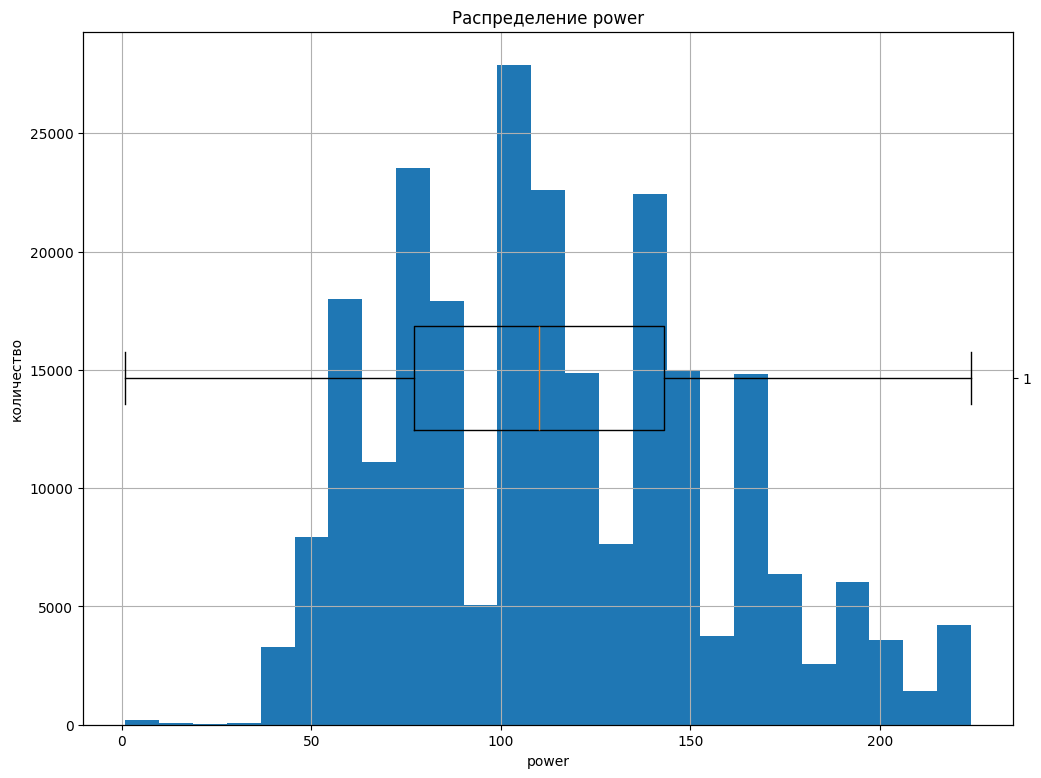

In [24]:

fig, ax = plt.subplots(figsize=(12, 9))

# Гистограмма
data['power'].dropna().hist(bins=25, ax=ax)
ax.set_xlabel('power')
ax.set_ylabel('количество')

# Ящик с усами
ax2 = ax.twinx()
ax2.boxplot(data['power'], vert=False)

plt.title('Распределение power')
plt.show()

посмотрим на распределение целвого признака

In [25]:
data['price'].value_counts()

price
0        4701
1500     3379
500      3314
2500     2863
1200     2834
         ... 
10760       1
2036        1
10830       1
1497        1
10985       1
Name: count, Length: 3442, dtype: int64

In [26]:
data = data[data['price']>0]

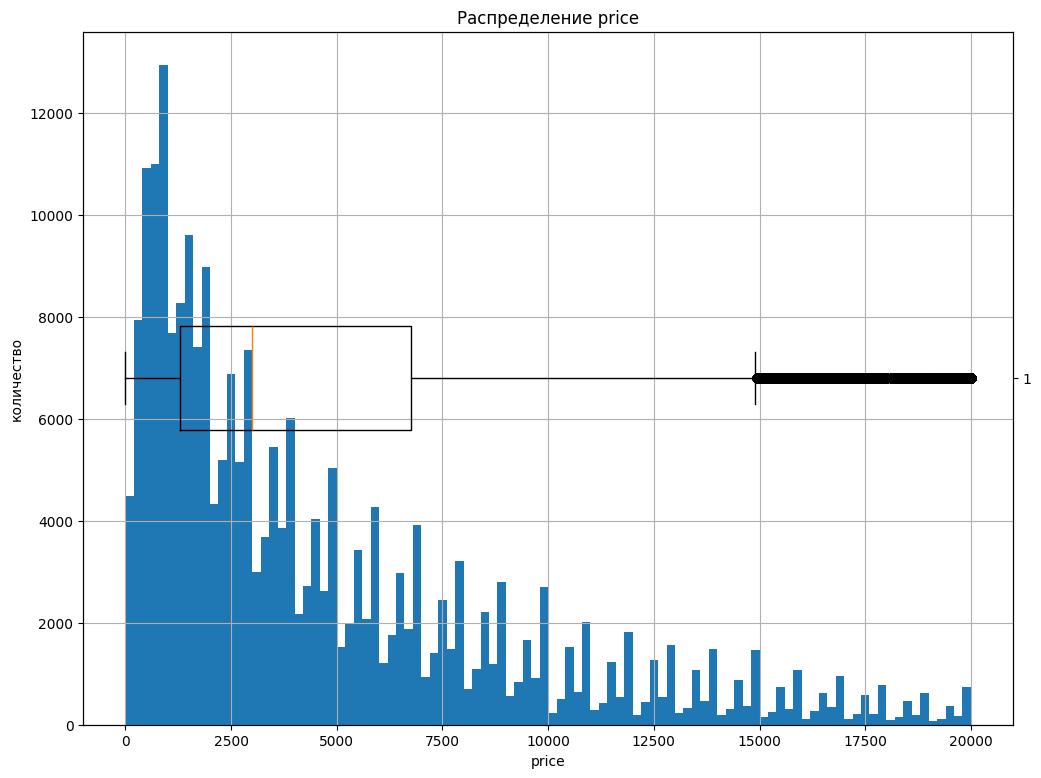

In [27]:
fig, ax = plt.subplots(figsize=(12, 9))

# Гистограмма
data['price'].dropna().hist(bins=100, ax=ax)
ax.set_xlabel('price')
ax.set_ylabel('количество')

# Ящик с усами
ax2 = ax.twinx()
ax2.boxplot(data['price'], vert=False)

plt.title('Распределение price')
plt.show()

In [28]:
# найдем количество пропусков
pd.concat([data.isna().sum(), (data.isna().sum() / len(data)) * 100], axis=1, keys=['количество', 'процент'])


,количество,процент
price,0,0.000000
vehicle_type,9810,4.161894
registration_year,0,0.000000
gearbox,4723,2.003733
power,0,0.000000
model,9033,3.832251
kilometer,0,0.000000
fuel_type,13816,5.861440
brand,0,0.000000
repaired,0,0.000000


пропуски остались только у строковых

In [29]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')
data['gearbox'] = data['gearbox'].fillna('unknown')
data['model'] = data['model'].fillna('unknown')
data['fuel_type'] = data['fuel_type'].fillna('other')


In [30]:
data.vehicle_type.value_counts()

vehicle_type
sedan          62165
small          57501
wagon          48324
bus            22822
convertible    14625
other          11884
coupe          10207
suv             8182
Name: count, dtype: int64

опять удалим ненужные дубликаты

In [31]:
data.duplicated().sum()
data = data.drop_duplicates().reset_index(drop=True)

на сколько сократился датасет после отбора подхобящих данных

In [32]:
((len_data_original - len(data)) / len_data_original) * 100

35.13907819250555

### Вывод

Были проанализированы исходные данные с использованием следующих шагов предобработки: удаление явных дубликатов, исключение неинформативных признаков и удаление 35% данных, которые не подходят для обучения модели. Далее было проведено исследование данных, включая обработку аномалий и выбросов, а также заполнение пропущенных значений. В результате этих действий был получен более чистый и надежный набор данных, готовый для дальнейшего анализа и использования.

## Обучение моделей

преобразование категориальных признаков в числовые с помощью горячего кодирования, исключая целевой признак 'price' из список признаков

In [33]:
# Разделяем выборки на обучающую и тестовую
target_ohe = data['price']
features_ohe = data.drop('price', axis=1)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe,
    target_ohe,
    test_size=0.25,
    random_state=12345)

# Прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train_ohe, drop_first=True)
features_test_ohe = pd.get_dummies(features_test_ohe, drop_first=True)

# Находим общие признаки между обучающей и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_test_ohe.columns)

# Оставляем в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

# Выводим размерности обучающей и тестовой выборок
print(features_train_ohe.shape, features_test_ohe.shape)

(172385, 297) (57462, 297)


масштабирование признаков с использованием стандартного масштабирования

In [34]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[features_train_ohe.columns])
features_train_ohe[features_train_ohe.columns] = scaler.fit_transform(features_train_ohe[features_train_ohe.columns])
features_test_ohe[features_test_ohe.columns] = scaler.transform(features_test_ohe[features_test_ohe.columns])

In [35]:
features_train_ohe.head()

,model_300c,model_jetta,fuel_type_petrol,brand_saab,model_espace,registration_year,model_mustang,model_1er,model_one,model_verso,...,model_touran,model_doblo,model_jimny,model_bravo,gearbox_unknown,model_getz,model_stilo,model_legacy,fuel_type_hybrid,brand_skoda
10267,-0.017702,-0.025724,0.787193,-0.03946,-0.041262,-0.853640,-0.014453,-0.110191,-0.056213,-0.034081,...,-0.101796,-0.033825,-0.027472,-0.032688,-0.144148,-0.035502,-0.042718,-0.023482,-0.027891,-0.139032
10424,-0.017702,-0.025724,0.787193,-0.03946,-0.041262,-0.853640,-0.014453,-0.110191,-0.056213,-0.034081,...,-0.101796,-0.033825,-0.027472,-0.032688,-0.144148,-0.035502,-0.042718,-0.023482,-0.027891,-0.139032
219596,-0.017702,-0.025724,0.787193,-0.03946,-0.041262,1.168665,-0.014453,-0.110191,-0.056213,-0.034081,...,-0.101796,-0.033825,-0.027472,-0.032688,-0.144148,-0.035502,-0.042718,-0.023482,-0.027891,-0.139032
17256,-0.017702,-0.025724,-1.270337,-0.03946,-0.041262,-0.669794,-0.014453,-0.110191,-0.056213,-0.034081,...,-0.101796,-0.033825,-0.027472,-0.032688,-0.144148,-0.035502,-0.042718,-0.023482,-0.027891,-0.139032
26571,-0.017702,-0.025724,0.787193,-0.03946,-0.041262,-0.669794,-0.014453,-0.110191,-0.056213,-0.034081,...,-0.101796,-0.033825,-0.027472,-0.032688,-0.144148,-0.035502,-0.042718,-0.023482,-0.027891,-0.139032


разделим выборки на обучающую и тестовую

In [36]:
target_oe = data['price']
features_oe = data.drop('price', axis=1)

# разделим выборки на обучающую и тестовую
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
    features_oe,
    target_oe,
    test_size=0.25,
    random_state=12345)


преобразование категориальных признаков в числовые с использованием метода кодирования порядковых значений

In [37]:
# порядковое кодирование (для "деревянных моделей")
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = features_train_oe.select_dtypes(include=['object']).columns

encoder.fit(features_train_oe[cat_columns])

features_train_oe = features_train_oe.copy()
features_test_oe = features_test_oe.copy()

features_train_oe[cat_columns] = encoder.transform(features_train_oe[cat_columns])
features_test_oe[cat_columns] = encoder.transform(features_test_oe[cat_columns])

print(features_train_oe.shape, features_test_oe.shape)

(172385, 9) (57462, 9)


приступим к обучению моделей

### Модель линейной регрессии

In [38]:
result = pd.DataFrame({'name':[],'model':[], 'RMSE':[], 'time_to_predict':[], 'time_to_fit':[]})

In [39]:
%%time
model_lr = LinearRegression()
start = time()
model_lr.fit(features_train_ohe, target_train_ohe)
time_to_fit = time() - start

start = time()
predicted = model_lr.predict(features_train_ohe)
time_to_predict = time() - start
rmse = mean_squared_error(target_train_ohe, predicted, squared=False)
result.loc[0] = ['LinearRegression',model_lr,rmse,time_to_predict,time_to_fit]
print('Модель предсказывает за %.2f секунд, обучается за %.2f секунд' % (time_to_predict, time_to_fit))
print('RMSE:', rmse)

Модель предсказывает за 0.12 секунд, обучается за 0.89 секунд
RMSE: 2235.5266446101364
CPU times: total: 6.38 s
Wall time: 1.02 s


C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Модель решающего дерева

In [40]:
%%time
params = {'max_depth': range(2,20)}

model_DTR = GridSearchCV(DecisionTreeRegressor(random_state=12345),
                     param_grid=params, scoring='neg_mean_absolute_error', cv=3)
start = time()
model_DTR.fit(features_train_oe, target_train_oe)
time_to_fit = time() - start
start = time()
predictions = model_DTR.predict(features_train_oe)
time_to_predict = time() - start
rmse = mean_squared_error(target_train_oe, predictions, squared=False)
print('Модель предсказывает за %.2f секунд, обучается за %.2f секунд' % (time_to_predict, time_to_fit))
print('RMSE:', rmse,'.с параметрами',model_DTR.best_params_)
result.loc[1] = ['DecisionTree',model_DTR,rmse,time_to_predict,time_to_fit]

Модель предсказывает за 0.02 секунд, обучается за 7.16 секунд
RMSE: 1190.6614263662834 .с параметрами {'max_depth': 16}
CPU times: total: 7.17 s
Wall time: 7.18 s


C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Модель случайного леса

In [41]:
%%time
params = {
    'max_depth': [11, 12, 13, 15],
    'n_estimators': [100, 300]
}


model_RF = RandomizedSearchCV(estimator = RandomForestRegressor(random_state=12345),
                              param_distributions=params, scoring='neg_mean_absolute_error', cv=3, n_iter=7,  n_jobs=-1, verbose=1)
start = time()
model_RF.fit(features_train_oe, target_train_oe)
time_to_fit = time() - start
start = time()
predictions = model_RF.predict(features_train_oe)
time_to_predict = time() - start

rmse = mean_squared_error(target_train_oe, predictions, squared=False)
print('Модель предсказывает за %.2f секунд, обучается за %.2f секунд' % (time_to_predict, time_to_fit))
print('RMSE:', rmse,'.с параметрами',model_RF.best_params_)
result.loc[2] = ['RandomForest',model_RF,rmse,time_to_predict,time_to_fit]

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Модель предсказывает за 5.44 секунд, обучается за 111.91 секунд
RMSE: 1200.142853186144 .с параметрами {'n_estimators': 300, 'max_depth': 15}
CPU times: total: 54 s
Wall time: 1min 57s


C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 ### LightGBM

In [42]:
%%time
params = {
    'max_depth': [5, 10, 15, 25],
    'learning_rate': [0.01, 0.1, 0.15]
}
print('подбор параметров')
model_LGBM = RandomizedSearchCV(estimator = LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE'),
                              param_distributions=params, scoring='neg_mean_absolute_error', cv=3, n_iter=10,  n_jobs=-1)
print('обучение')
start = time()
model_LGBM.fit(features_train_oe, target_train_oe)
time_to_fit = time() - start
start = time()
predictions = model_LGBM.predict(features_train_oe)
time_to_predict = time() - start

rmse = mean_squared_error(target_train_oe, predictions, squared=False)
print('Модель предсказывает за %.2f секунд, обучается за %.2f секунд' % (time_to_predict, time_to_fit))
print('RMSE:', rmse,'.с параметрами',model_LGBM.best_params_)
result.loc[3] = ['LightGBM',model_LGBM,rmse,time_to_predict,time_to_fit]

подбор параметров
обучение
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 554
[LightGBM] [Info] Number of data points in the train set: 172385, number of used features: 9
[LightGBM] [Info] Start training from score 4708.535482
Модель предсказывает за 0.06 секунд, обучается за 5.83 секунд
RMSE: 1463.8501872937152 .с параметрами {'max_depth': 10, 'learning_rate': 0.15}
CPU times: total: 3.16 s
Wall time: 5.89 s


C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### XGBoost

In [43]:
%%time
params = {
    'max_depth': [12, 13, 14],
    'learning_rate': [0.1, 0.15, 0.3]
}


print('подбор параметров')
model_XGB = RandomizedSearchCV(estimator = XGBRegressor(booster='gbtree',
                      eval_metric='rmse',
                      use_rmm=True),
                        param_distributions=params, scoring='neg_mean_absolute_error', cv=3, n_iter=8,  n_jobs=-1,verbose=1)
print('обучение')
start = time()
model_XGB.fit(features_train_oe, target_train_oe)
time_to_fit = time() - start
start = time()
predictions = model_XGB.predict(features_train_oe)
time_to_predict = time() - start
rmse = mean_squared_error(target_train_oe, predictions, squared=False)
print('Модель предсказывает за %.2f секунд, обучается за %.2f секунд' % (time_to_predict, time_to_fit))
print('RMSE:', rmse,'.с параметрами',model_XGB.best_params_)
result.loc[4] = ['XGBoost',model_XGB,rmse,time_to_predict,time_to_fit]


подбор параметров
обучение
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Модель предсказывает за 0.08 секунд, обучается за 13.40 секунд
RMSE: 1060.8937108873622 .с параметрами {'max_depth': 12, 'learning_rate': 0.1}
CPU times: total: 17.7 s
Wall time: 13.5 s


C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### CatBoost

In [44]:
%%time
params = {
    'max_depth': [8, 11, 12],
    'learning_rate': [0.01, 0.2]
}
print('подбор параметров')
model_CatBoost = RandomizedSearchCV(estimator = CatBoostRegressor(verbose=1),
                        param_distributions=params, scoring='neg_mean_absolute_error', cv=3, n_iter=6,  n_jobs=-1)

print('обучение')
start = time()
model_CatBoost.fit(features_train_oe, target_train_oe)
time_to_fit = time() - start
start = time()
predictions = model_CatBoost.predict(features_train_oe)
time_to_predict = time() - start
rmse = mean_squared_error(target_train_oe, predictions, squared=False)
print('Модель предсказывает за %.2f секунд, обучается за %.2f секунд' % (time_to_predict, time_to_fit))
print('RMSE:', rmse,'.с параметрами',model_CatBoost.best_params_)
result.loc[5] = ['CatBoost',model_CatBoost,rmse,time_to_predict,time_to_fit]

подбор параметров
обучение


C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline,
           ^^^^^^^^^^^^

0:	learn: 3808.3910384	total: 150ms	remaining: 2m 29s
1:	learn: 3322.4728883	total: 159ms	remaining: 1m 19s
2:	learn: 2950.9191319	total: 166ms	remaining: 55.3s
3:	learn: 2674.4317281	total: 175ms	remaining: 43.5s
4:	learn: 2456.8918514	total: 183ms	remaining: 36.3s
5:	learn: 2282.4199018	total: 190ms	remaining: 31.4s
6:	learn: 2163.7385997	total: 196ms	remaining: 27.8s
7:	learn: 2069.2935196	total: 203ms	remaining: 25.2s
8:	learn: 1998.3419131	total: 209ms	remaining: 23s
9:	learn: 1940.9624846	total: 216ms	remaining: 21.4s
10:	learn: 1897.7310209	total: 223ms	remaining: 20s
11:	learn: 1863.5412737	total: 229ms	remaining: 18.8s
12:	learn: 1822.5912306	total: 235ms	remaining: 17.9s
13:	learn: 1796.7231633	total: 242ms	remaining: 17s
14:	learn: 1766.0087667	total: 248ms	remaining: 16.3s
15:	learn: 1747.9037814	total: 254ms	remaining: 15.7s
16:	learn: 1730.7157651	total: 261ms	remaining: 15.1s
17:	learn: 1712.5268068	total: 268ms	remaining: 14.6s
18:	learn: 1697.4824134	total: 274ms	remai

C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [45]:
result.head(10)

,name,model,RMSE,time_to_predict,time_to_fit
0,LinearRegression,LinearRegression(),2235.526645,0.123198,0.892126
1,DecisionTree,"GridSearchCV(cv=3, estimator=DecisionTreeRegre...",1190.661426,0.024508,7.157150
2,RandomForest,"RandomizedSearchCV(cv=3, estimator=RandomFores...",1200.142853,5.444194,111.907524
3,LightGBM,"RandomizedSearchCV(cv=3,\n e...",1463.850187,0.063049,5.827842
4,XGBoost,"RandomizedSearchCV(cv=3,\n e...",1060.893711,0.077024,13.400950
5,CatBoost,"RandomizedSearchCV(cv=3,\n e...",1238.641626,0.015558,91.387677


## Анализ моделей

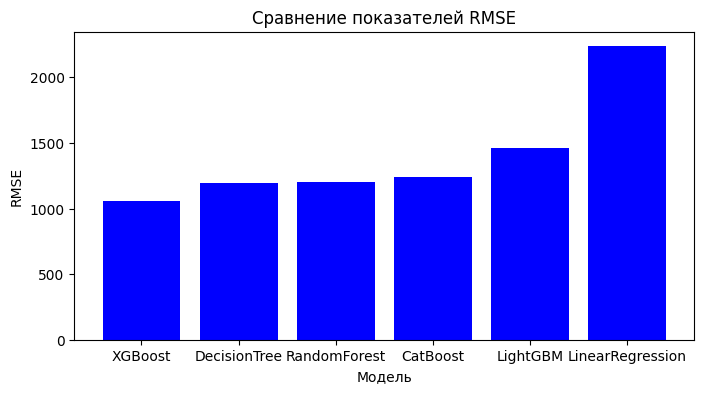

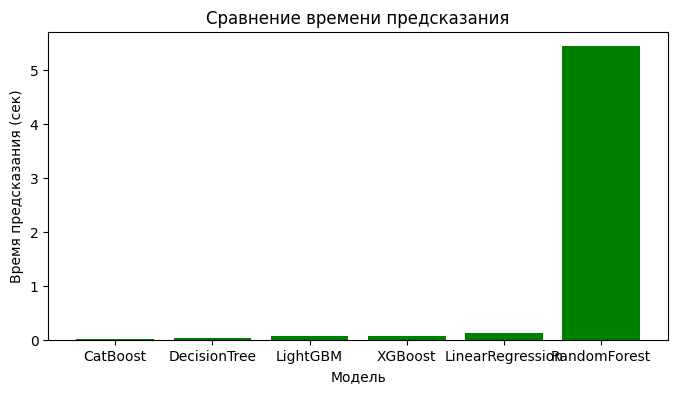

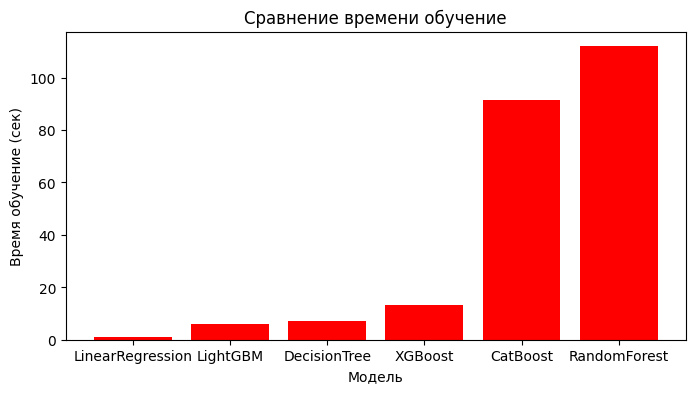

Лучшая модель по RMSE: XGBoost
Лучшая модель по времени предсказания: CatBoost
Лучшая модель по времени обучения: LinearRegression


In [48]:
# График RMSE
plt.figure(figsize=(8, 4))
result = result.sort_values(by='RMSE')
plt.bar(result['name'], result['RMSE'], color='blue')
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.title('Сравнение показателей RMSE')
plt.show()

# График time_to_predict
plt.figure(figsize=(8, 4))
result = result.sort_values(by='time_to_predict')
plt.bar(result['name'], result['time_to_predict'], color='green')
plt.xlabel('Модель')
plt.ylabel('Время предсказания (сек)')
plt.title('Сравнение времени предсказания')
plt.show()

# График time_to_fit
plt.figure(figsize=(8, 4))
result = result.sort_values(by='time_to_fit')
plt.bar(result['name'], result['time_to_fit'], color='red')
plt.xlabel('Модель')
plt.ylabel('Время обучение (сек)')
plt.title('Сравнение времени обучение')
plt.show()


best_model_rmse = result['name'][result['RMSE'].idxmin()]
print('Лучшая модель по RMSE:', best_model_rmse)


best_model_time = result['name'][result['time_to_predict'].idxmin()]
print('Лучшая модель по времени предсказания:', best_model_time)

best_model_time_fit = result['name'][result['time_to_fit'].idxmin()]
print('Лучшая модель по времени обучения:', best_model_time_fit)

По результатам изучения моделей LinearRegression, DecisionTree, RandomForest, LightGBM, XGBoost и CatBoost на тренировочной выборк

1. Модель XGBoost показывает наилучшую производительность среди всех моделей. Она демонстрирует наименьшую ошибку RMSE в размере 1060, что говорит о её хорошей предсказательной способности для данного набора данных. Время предсказания составляет 0.07 секунды, а время обучения модели - 13 секунд.

1. Модель RandomForest также показывает хорошие результаты с RMSE ошибкой в размере 1200. Однако, она требует значительно больше времени для обучения (111 секунды) и предсказания (5.4 секунды) по сравнению с XGBoost. Если  есть ограниченные ресурсы вычислений или большие объемы данных, время, необходимое для работы с RandomForest, может быть значимым фактором.

1. Модель CatBoost показывает RMSE ошибку в размере 1238, время предсказания составляет 0.01 секунды, а время обучения модели - 91. секунды. LightGBM также продемонстрировала некоторое улучшение по сравнению с предыдущими результатами, но она все равно уступает XGBoost в точности предсказания.

1. Модели LinearRegression и LightGBM продемонстрировали самые высокие значения RMSE ошибки среди всех моделей в списке. LinearRegression имеет RMSE ошибку в размере 2235, в то время как LightGBM имеет RMSE ошибку в размере 1463. 

Исходя из результатов, модель XGBoost наиболее перспективная модель для данного набора данных.

Заказчику важны:

- качество предсказания
- скорость предсказания
- время обучения.

отдельно время обучения, время предсказания преведены в гистограме выше
Для анализа моделей и выборе компетентной заказчику. рассмотрим 4 модели с лучшим показателем RMSE. Так как это самый важный показатель. 
- XGBoost - 1060
- RandomForest - 1200
- DecisionTree - 1190
- CatBoost - 1238
- Остальные модели показали еще более высокие значения RMSE (>1400), что указывает на их низкую эффективность

по имеющимся 4 лучшим моделям выберем подходящую на основе времени предсказания и обучения

время предсказания
- CatBoost - 0.01
- DecisionTree - 0.02
- LightGBM - 0.06
- XGBoost - 0.07


и последней критерий - время обучения
- LinearRegression - 0.89
- LightGBM - 5.82
- DecisionTree - 7.15
- XGBoost - 13.4


На основе критериев заказчика выбор XGBoost является оптимальным по следующим причинам:
- XGBoost: 1060 - лучший показатель
- XGBoost: 0.07 сек - немного уступает другим моделям, Но разница между 0.01 (CatBoost) и 0.07 (XGBoost) составляет всего 0.06 секунды, что незначительно для большинства практических задач
- XGBoost: 13.4 сек - дольше других моделей, однако это одноразовая операция, в то время как прогнозирование выполняется многократно
Время обучения - то одноразовая операция, в то время как прогнозирование выполняется многократно

В контексте задачи прогнозирования цен на автомобили, где погрешность в прогнозе может составлять десятки тысяч рублей, существенное улучшение RMSE значительно важнее, чем незначительные потери во времени предсказания.


## Тестирование лучшей модели

Рассмотрим скорость обучения итогововых моделей и метрик на тестовой выборке:

In [49]:
start = time()
predicted = result['model'][result['RMSE'].idxmin()].predict(features_test_oe)
print('Модель ',result['name'][result['RMSE'].idxmin()],' предсказывает не тестовой выборке за %.2f секунд' %(time() - start))

rmse_on_test = mean_squared_error(target_test_oe, predicted, squared=False)
print('Итоговый RMSE на тестовой выборке:', rmse_on_test)

Модель  XGBoost  предсказывает не тестовой выборке за 0.04 секунд
Итоговый RMSE на тестовой выборке: 1445.9652500752736


C:\Users\saveliy\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Таким образом, модель XGBoost с параметрами max_depth: 12 и learning_rate: 0.1 обладает хорошей предсказательной способностью и эффективностью.

## Вывод

В ходе исследования были выполнены шаги предобработки данных, включая удаление дубликатов, исключение неинформативных признаков и обработку пропущенных значений. Данные были подготовлены для дальнейшего анализа и обучения моделей.

Были изучены и сравнены различные модели, включая LinearRegression, DecisionTree, RandomForest, LightGBM, XGBoost и CatBoost. Модель XGBoost продемонстрировала наилучшую точность предсказания на тренировочной выборке с наименьшей ошибкой RMSE = 1060, что говорит о ее хорошей предсказательной способности. Она показала хорошую точность предсказания и на тестовой выборке RMSE = 1445 и относительно низкое время предсказания (0.04 с), соответствуя критериям, важным для заказчика.

Таким образом, рекомендуется использовать модель XGBoost с оптимальными параметрами для дальнейшего прогнозирования на основе данного набора данных.